In [1]:
import numpy as np
from jax import vmap
import matplotlib.pyplot as plt

from distributions import Gaussian, Mixture
from discrepancies import (
    FisherDivergence,
    KernelSteinDiscrepancy,
    MaximumMeanDiscrepancy,
)
from kernels import InverseMultiQuadraticKernel, SteinKernel

In [2]:
np.random.seed(0)

# Score Functions

We introduce the concept of the score function $\psi_p(x; \theta)$ for a probability distribution $p(x; \theta)$:

$$\psi_p(x; \theta) = \nabla_x \log p(x; \theta)$$

a mapping $\mathbb{R}^d \rightarrow \mathbb{R}^d$.

However, assuming $p(x; \theta)$ is of the form:

$$p(x; \theta) = \frac{1}{z(\theta)}\tilde{p}(x; \theta)$$

For convenience, we can redefine:

$$\psi_p(x; \theta) = \nabla_x \log \tilde{p}(x; \theta)$$


Similarly, if we have a set of observed data $\mathcal{D}$ such that 
$$\mathcal{D} = \{x_i \sim \mathbb{Q}\}$$
where $i = 1,2,...,n$

We can write the score function of $q(x)$, the distribution of $\mathcal{D}$ as:

$$\psi_q(x) = \nabla_x \log q(x)$$


## Gaussian

For Gaussian distributions, we know:

$$p(x) = p(x; \mu, \Sigma) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}} \exp(-\frac{1}{2}(x-\mu)^T \Sigma^{-1}(x-\mu))$$

where 

$$\tilde{p}(x) =\exp(-\frac{1}{2}(x-\mu)^T \Sigma^{-1}(x-\mu)) $$

and

$$\nabla_x \log \tilde{p}(x) =  -\Sigma^{-1} (x-\mu)$$

We can visualise this for a few Gaussian distributions:

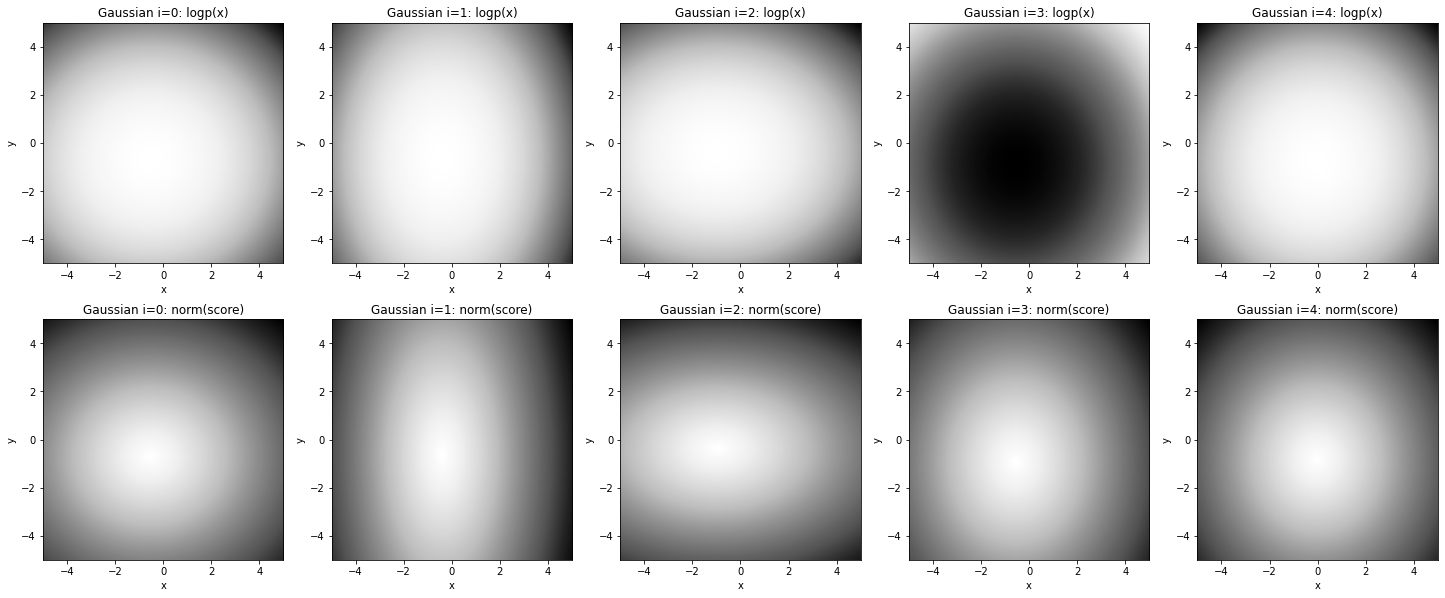

In [3]:
num_gaussians = 5
num_dimensions = 2

N = 101
M = 101
x_min, x_max = -5, 5
y_min, y_max = -5, 5
x_ticks = np.linspace(x_min, x_max, N)
y_ticks = np.linspace(y_min, y_max, M)
xx, yy = np.meshgrid(x_ticks, y_ticks)
x = np.stack((xx, yy)).reshape(2, N * M).T

fig, ax = plt.subplots(2, num_gaussians)
fig.set_figwidth(5 * num_gaussians)
fig.set_figheight(10)

for i in range(num_gaussians):
    gaussian = Gaussian(
        mu=np.random.rand(
            num_dimensions,
        ),
        covariance=np.diag(np.random.rand(num_dimensions)),
    )
    ax[0][i].imshow(
        np.flip(vmap(gaussian.log_p)(x).reshape(xx.shape), axis=1),
        cmap="Greys",
        extent=[x_min, x_max, y_min, y_max],
    )
    ax[0][i].set_xlabel("x")
    ax[0][i].set_ylabel("y")
    ax[0][i].set_title(f"Gaussian {i=}: logp(x)")

    ax[1][i].imshow(
        np.flip(
            np.linalg.norm(vmap(gaussian.score)(x), axis=1).reshape(xx.shape), axis=1
        ),
        cmap="Greys",
        extent=[x_min, x_max, y_min, y_max],
    )
    ax[1][i].set_xlabel("x")
    ax[1][i].set_ylabel("y")
    ax[1][i].set_title(f"Gaussian {i=}: norm(score)")

# Fisher Divergence

The score can be viewed as a "feature" of the original distribution, or a unique mapping like the kernels of MMD and KSD which are characterstic (captures all information about the distribution $\mathbb{P}$). As such, if we compare the scores of two distributions, we can define an measure of discrepancy between the two distributions. This is the formulation of the Fisher Divergence:

$$J = \frac{1}{2}\mathbb{E}_{x\sim\mathbb{Q}}[||\psi_p(x; \theta)-\psi_q(x)||^2]$$

the expectation of the squared distance between $\psi_p(x; \theta)$, the known distribution score function and $\psi_q(x)$, the observed data score function with resepect to $q(x)$.

This can be rewritten as:

$$J = \frac{1}{2}\int_{x \in \mathbb{R}^d}q(x) || \psi_p(x; \theta)-\psi_q(x)||^2 dx$$

We can see that we only have samples from $q(x)$, approximating the normalising constant of this function is intractable.

However, assuming the condiitons that:

- $q(x)$ is differentiable
- $\mathbb{E}_{x\sim\mathbb{Q}}[||\psi_p(x; \theta)||^2]$ and $\mathbb{E}_{x\sim\mathbb{Q}}[||\psi_q(x)||^2]$ are finite for any $\theta$
- $q(x)\psi_p(x; \theta) \rightarrow 0$ $\forall \theta$ when $||x|| \rightarrow \infty$

It can be shown that:

$$J = \int_{x \in \mathbb{R}^d}q(x) \sum_{i=1}^{n}[ \partial_i \psi_{p_i}(x; \theta)+\frac{1}{2}\psi_{p_i}(x, \theta)^2] dx + const.$$

where the constant does not depend on $\theta$ and

$$\partial_i \psi_{p_i}(x; \theta) = \frac{\partial^2 \log \tilde{p}(x; \theta)}{\partial x_i^2}$$

The numerical estimate for $J$:

$$\tilde{J} = \frac{1}{n} \sum_i^n \sum_j^d [\partial_j \psi_{p_j}(x_i; \theta)+\frac{1}{2}\psi_{p_j}(x_i, \theta)^2] + const.$$

where $n$ is the number of observed data points and $d$ is the dimensionality of the data.

We can visualise the Fisher Divergence for a number of Gaussians with each of their covariance scaled differently.

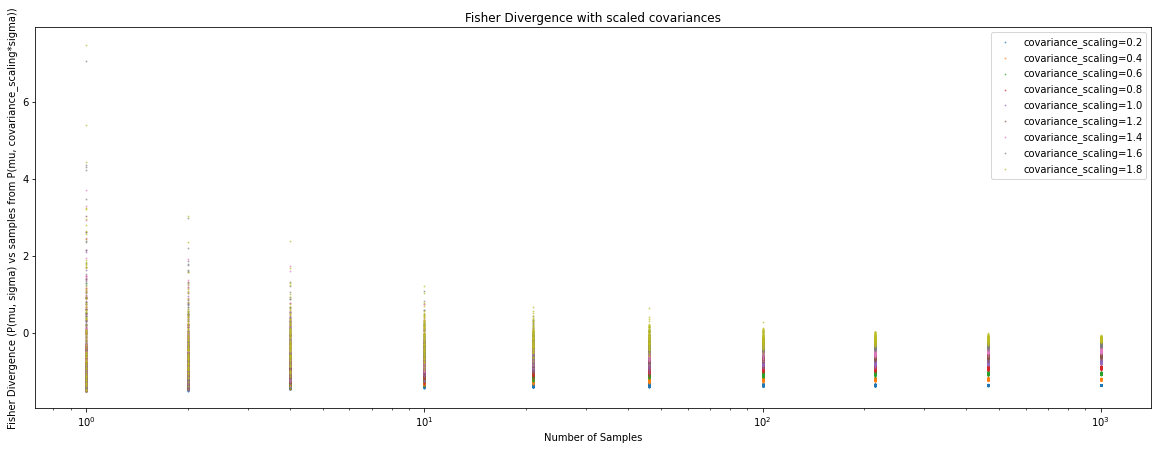

In [4]:
mu = np.array([10, 10]).reshape(
    -1,
)
covariance = np.array(
    [
        [1, 0],
        [0, 2],
    ]
)
p_base = Gaussian(mu, covariance)
covariance_scalings = np.round(np.arange(0.2, 2, 0.2), 3)
ps = [
    Gaussian(mu, covariance_scaling * covariance)
    for covariance_scaling in covariance_scalings
]

n_trials = 100
n_samples = np.logspace(0, 3, 10).astype(int)
p_samples = []
for p in ps:
    p_samples.append([p.sample((n_trials, n_sample)) for n_sample in n_samples])

fisher_vals_p = np.zeros((len(covariance_scalings), n_trials, len(n_samples)))

fisher_divergence = FisherDivergence(p=p_base)


for i in range(len(n_samples)):
    for j in range(len(ps)):
        fisher_vals_p[j, :, i] = vmap(
            lambda sample_i: fisher_divergence.compute(sample_i)
        )(p_samples[j][i])

fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(7)
ax = fig.add_subplot(1, 1, 1)
for i, covariance_scaling in enumerate(covariance_scalings):
    plt.scatter(
        np.repeat(n_samples, n_trials).reshape(-1, n_trials).T.flatten(),
        fisher_vals_p[i, :, :].flatten(),
        s=1,
        alpha=5e-1,
        label=f"{covariance_scaling=}",
    )
ax.set_xscale("log")
ax.set_title("Fisher Divergence with scaled covariances")
ax.set_xlabel("Number of Samples")
ax.set_ylabel(
    "Fisher Divergence (P(mu, sigma) vs samples from P(mu, covariance_scaling*sigma))"
)
plt.legend()
plt.show()

Here we can see the importance of having sufficient samples from our distributions to be able to visualise that the Fisher Divergence for the distributions form distinct clusters.

# Mixture Distributions

A limitation of the Fisher divergence is its inability to differentiate between certain sets of multi modal distributions. We show this by first defining a mixture distribution composed of $n$ distributions:

$$p(x) = \sum_{i=1}^n w_i p_i(x)$$

where $\sum_{i=1}^n w_i = 1$.

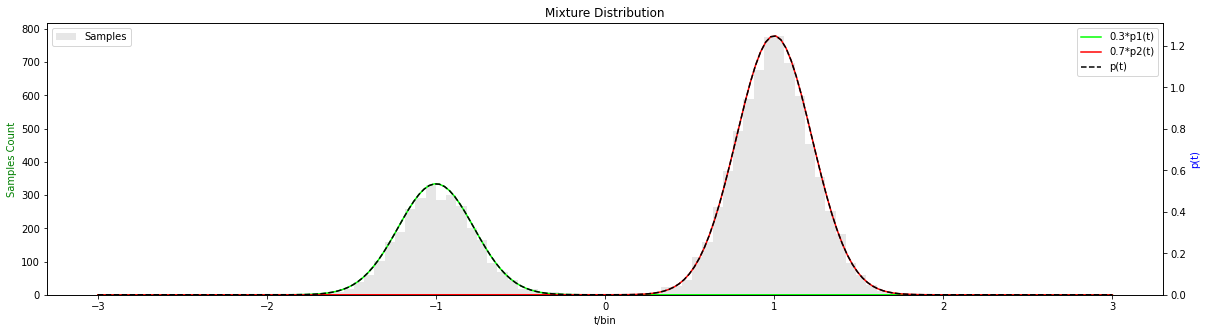

In [5]:
p1 = Gaussian(mu=-np.ones((1,)), covariance=0.05 * np.ones((1, 1)))
p2 = Gaussian(mu=np.ones((1,)), covariance=0.05 * np.ones((1, 1)))
p_mix = Mixture(weights=[0.3, 0.7], distributions=[p1, p2])

z = p_mix.sample(int(1e4))
bins = np.linspace(-3, 3, 100)
bin_size = bins[1] - bins[0]
count, bins = np.histogram(z, bins)

t = np.linspace(-3, 3, 200).reshape(-1, 1)

fig, ax1 = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(5)
ax2 = ax1.twinx()
ax1.bar(
    bins[1:] - bin_size / 2, count, bin_size, color=(0.9, 0.9, 0.9), label="Samples"
)

ax2.plot(
    t,
    p_mix.weights[0] * vmap(lambda t_i: p1.p(t_i))(t),
    c=(0, 1, 0),
    label=f"{p_mix.weights[0]}*p1(t)",
)
ax2.plot(
    t,
    p_mix.weights[1] * vmap(lambda t_i: p2.p(t_i))(t),
    c=(1, 0, 0),
    label=f"{p_mix.weights[1]}*p2(t)",
)
ax2.plot(
    t, vmap(lambda t_i: p_mix.p(t_i))(t), c="black", linestyle="dashed", label="p(t)"
)


plt.title("Mixture Distribution")
ax1.set_xlabel("t/bin")
ax1.set_ylabel("Samples Count", color="g")
ax2.set_ylabel("p(t)", color="b")
ax2.set_ylim(bottom=0)
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()

When we change the weights of this mixture distribution, we will see that the Fisher divergence is unable to differentiate between them like when we changed the covariance of a distribution before. 

In [6]:
n_t = 200
n_trials = 10
n_weights = 6
n_samples = np.ceil(np.logspace(np.log(2) / np.log(10), 3, 10)).astype(int)

t = np.linspace(-3, 3, n_t).reshape(-1, 1)
pdfs = np.zeros((n_weights, n_t))
weights = np.round(np.linspace(0, 1, n_weights), 2)
fisher_vals_p = np.zeros((n_weights, n_trials, len(n_samples)))
ksd_vals_p = np.zeros((n_weights, n_trials, len(n_samples)))
mmd_vals_p = np.zeros((n_weights, n_trials, len(n_samples)))


fisher_divergence = FisherDivergence(p_mix)

stein_kernel = SteinKernel(
    distribution=p_mix, kernel=InverseMultiQuadraticKernel(c=0.5, beta=-0.5)
)
ksd = KernelSteinDiscrepancy(stein_kernel=stein_kernel)

mmd = MaximumMeanDiscrepancy(kernel=InverseMultiQuadraticKernel(c=0.5, beta=-0.5))
mmd_samples = p_mix.sample(np.max(n_samples))

for i, weight in enumerate(weights):
    p_mix_i = Mixture(weights=[weight, 1 - weight], distributions=[p1, p2])
    pdfs[i, :] = vmap(lambda t_i: p_mix_i.p(t_i))(t)
    for k, n_sample in enumerate(n_samples):
        z = p_mix_i.sample((n_trials, n_sample))
        fisher_vals_p[i, :, k] = vmap(
            lambda z_i: fisher_divergence.compute(z_i.reshape(-1, 1))
        )(z).T
        ksd_vals_p[i, :, k] = vmap(lambda z_i: ksd.compute(z_i.reshape(-1, 1)))(z).T
        mmd_vals_p[i, :, k] = vmap(
            lambda z_i: mmd.compute(mmd_samples.reshape(-1, 1), z_i.reshape(-1, 1))
        )(z).T

We can visualise the different distributions being compared.

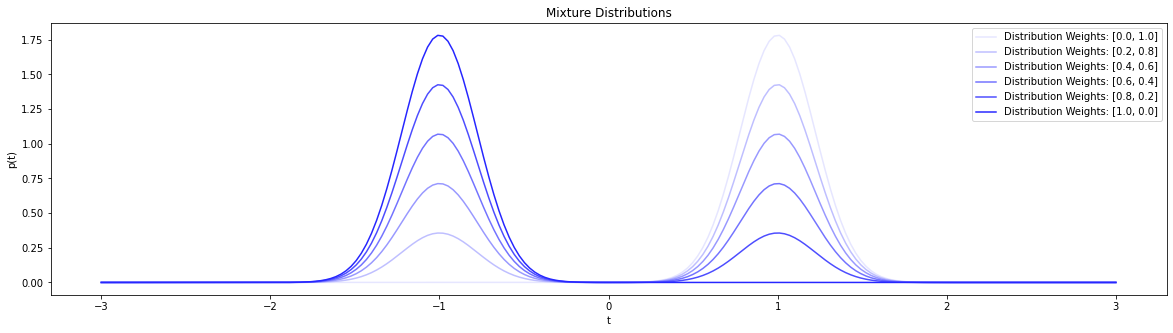

In [7]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(20)
fig.set_figheight(5)
for i, weight in enumerate(weights):
    shade = 0.9 * (len(weights) - i) / len(weights)
    ax.plot(
        t,
        pdfs[i, :],
        c=(shade, shade, 1),
        label=f"Distribution Weights: [{weight}, {np.round(1-weight, 2)}]",
    )
ax.set_title("Mixture Distributions")
ax.set_xlabel("t")
ax.set_ylabel("p(t)")
ax.legend()
plt.show()

We can visualise the Fisher Divergence and KSD values.

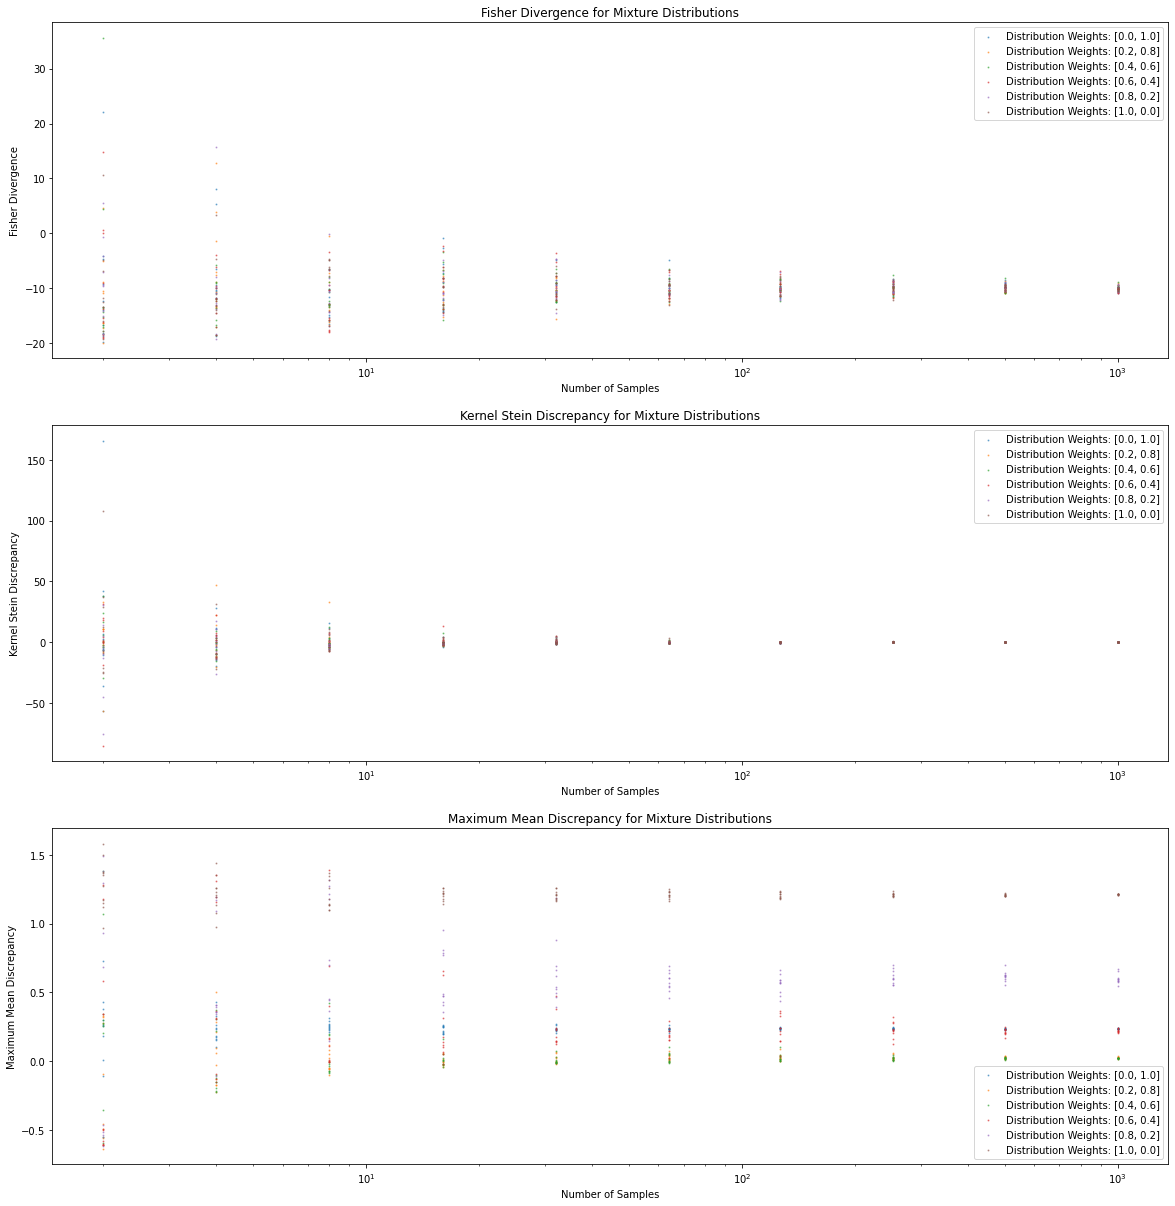

In [8]:
fig, ax = plt.subplots(3, 1)
fig.set_figwidth(20)
fig.set_figheight(21)
for i, weight in enumerate(weights):
    ax[0].scatter(
        np.repeat(n_samples, n_trials).reshape(-1, n_trials).T.flatten(),
        fisher_vals_p[i, :, :].flatten(),
        s=1,
        alpha=5e-1,
        label=f"Distribution Weights: [{weight}, {np.round(1-weight, 2)}]",
    )
ax[0].set_xscale("log")
ax[0].set_title("Fisher Divergence for Mixture Distributions")
ax[0].set_xlabel("Number of Samples")
ax[0].set_ylabel("Fisher Divergence")
ax[0].legend()

for i, weight in enumerate(weights):
    ax[1].scatter(
        np.repeat(n_samples, n_trials).reshape(-1, n_trials).T.flatten(),
        ksd_vals_p[i, :, :].flatten(),
        s=1,
        alpha=5e-1,
        label=f"Distribution Weights: [{weight}, {np.round(1-weight, 2)}]",
    )
ax[1].set_xscale("log")
ax[1].set_title("Kernel Stein Discrepancy for Mixture Distributions")
ax[1].set_xlabel("Number of Samples")
ax[1].set_ylabel("Kernel Stein Discrepancy")
ax[1].legend()

for i, weight in enumerate(weights):
    ax[2].scatter(
        np.repeat(n_samples, n_trials).reshape(-1, n_trials).T.flatten(),
        mmd_vals_p[i, :, :].flatten(),
        s=1,
        alpha=5e-1,
        label=f"Distribution Weights: [{weight}, {np.round(1-weight, 2)}]",
    )
ax[2].set_xscale("log")
ax[2].set_title("Maximum Mean Discrepancy for Mixture Distributions")
ax[2].set_xlabel("Number of Samples")
ax[2].set_ylabel("Maximum Mean Discrepancy")
ax[2].legend()

plt.show()

From the above plot we can see that for the Fisher divergence, as the number of samples increases, the values for all distributions cluster to a single point, showing that it is unable to differentiate between them. Similarly, the KSD, which also uses the scores of distributions, is also unable to differeniate the distributions. On the other hand, we see that the MMD is still capable of differentiating between distributions.

## Witness Functions

We can explore this in more depth by comparing the witness functions of the MMD and the KSD.

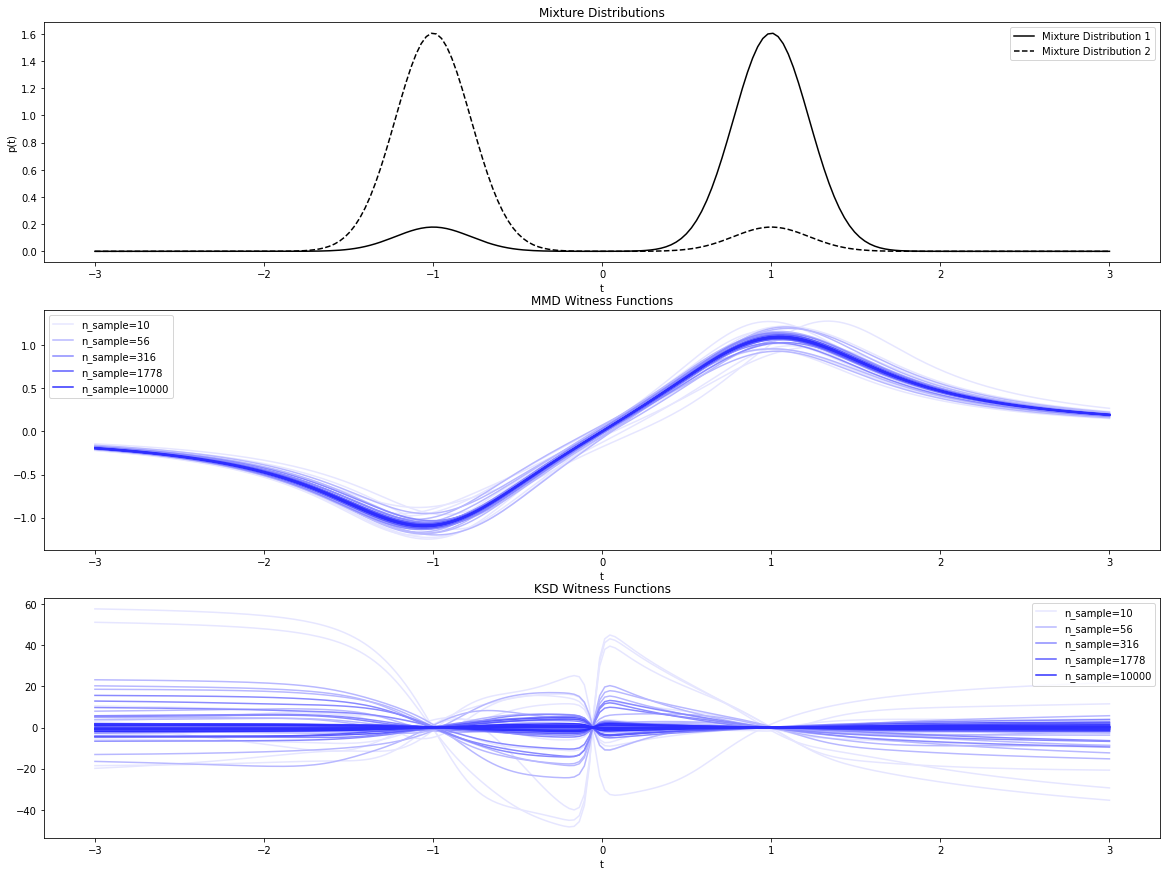

In [9]:
n_trials = 10
n_samples = np.logspace(1, 4, 5).astype(int)
fig, ax = plt.subplots(3, 1)
fig.set_figwidth(20)
fig.set_figheight(15)
t = np.linspace(-3, 3, 200).reshape(-1, 1)
p_mix_1 = Mixture(weights=[0.1, 0.9], distributions=[p1, p2])
p_mix_2 = Mixture(weights=[0.9, 0.1], distributions=[p1, p2])


mmd = MaximumMeanDiscrepancy(kernel=InverseMultiQuadraticKernel(c=0.5, beta=-0.5))
stein_kernel = SteinKernel(
    distribution=p_mix_1, kernel=InverseMultiQuadraticKernel(c=0.5, beta=-0.5)
)
ksd = KernelSteinDiscrepancy(stein_kernel=stein_kernel)
for i, n_sample in enumerate(n_samples):
    for j in range(n_trials):
        x = p_mix_1.sample(n_sample).reshape(-1, 1)
        y = p_mix_2.sample(n_sample).reshape(-1, 1)
        mmd_witness_values = mmd.witness_function(x, y, t)
        ksd_witness_values = ksd.witness_function(
            x=y,
            t=t,
        )
        shade = 0.9 * (len(n_samples) - i) / len(n_samples)
        if j == 0:
            ax[1].plot(
                t,
                mmd_witness_values,
                c=(shade, shade, 1),
                label=f"{n_sample=}",
            )
            ax[2].plot(
                t,
                ksd_witness_values,
                c=(shade, shade, 1),
                label=f"{n_sample=}",
            )
        else:
            ax[1].plot(t, mmd_witness_values, c=(shade, shade, 1))
            ax[2].plot(t, ksd_witness_values, c=(shade, shade, 1))
ax[0].plot(
    t, vmap(lambda t_i: p_mix_1.p(t_i))(t), label="Mixture Distribution 1", c="black"
)
ax[0].plot(
    t,
    vmap(lambda t_i: p_mix_2.p(t_i))(t),
    label="Mixture Distribution 2",
    c="black",
    linestyle="dashed",
)

ax[0].set_title("Mixture Distributions")
ax[0].set_xlabel("t")
ax[0].set_ylabel("p(t)")
ax[0].legend()

ax[1].set_title("MMD Witness Functions")
ax[1].set_xlabel("t")
ax[1].legend()
ax[2].set_title("KSD Witness Functions")
ax[2].set_xlabel("t")
ax[2].legend()
plt.show()

From these plots, we can see that the witness functions of the MMD indicate the discrepancies between the two distirbutions. On the other hand, for the KSD we see that there is much more noise in the witness functions and they are unable to indicate the discrepancies between the distributions as clearly as the MMD.